In [1]:
!pip install kaggle tensorflow numpy pandas matplotlib scikit-learn split-folders

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"elhamlolo","key":"b56e2dd61367e682bf5fca1b0a1ea222"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
!unzip ct-kidney-dataset-normal-cyst-tumor-and-stone.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4364).jpg  
  inflating: dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4365).jpg  
  inflating: dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4366).jpg  
  inflating: dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4367).jpg  
  inflating: dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4368).jpg  
  inflating: dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4369).jpg  
  inflating: dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (437).jpg  
  inflating: datase

In [6]:
import os
import splitfolders
import random
import sys
import shutil
import logging
import cv2
import requests
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt
import tensorflow        as tf
from   tensorflow.keras.models        import load_model
from   tensorflow.keras.applications  import VGG16, ResNet50, MobileNetV2,InceptionResNetV2, InceptionV3,DenseNet201, Xception, EfficientNetB0
from   tensorflow.keras.models        import Sequential, Model
from   tensorflow.keras.layers        import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from   tensorflow.keras.preprocessing import image
from   tensorflow.keras.preprocessing.image import ImageDataGenerator
from   keras.callbacks                import EarlyStopping
from   sklearn.metrics                import accuracy_score, confusion_matrix,  precision_score, recall_score, classification_report, f1_score, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from   io                             import BytesIO
from   PIL                            import Image

In [2]:
import sys
import tensorflow as tf
print ("Python version is     : " , sys.version   )
print ("tensorflow version is : " , tf.__version__)

# Get detailed information about GPU(s)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("\nTensorFlow is using the following GPU(s):")
    for gpu in gpus:
        print(gpu)
else:
    print("\nNo GPU detected or TensorFlow is not configured to use one.")

Python version is     :  3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
tensorflow version is :  2.19.0

TensorFlow is using the following GPU(s):
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [7]:
environment = 'colab'

if environment =='colab':
  inputFolder  = '/content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/'
  outputFolder = '/content/dataset/CT_split/'
  results_path  = '/content/dataset/Results/'

else:
  inputFolder  = 'E:\\____My2024 Work\\___Research_Points\\Now\\Kidney Classification\\dataset\\All\\CT_dataset\\'
  outputFolder = 'E:\\____My2024 Work\\___Research_Points\\Now\\Kidney Classification\\dataset\\All\\CT_split\\'
  results_path  = 'E:\\____My2024 Work\\___Research_Points\\Now\\Kidney Classification\\Codes\My_Codes\\Results\\'

if not os.path.exists(results_path):
    os.makedirs(results_path)

<>:11: SyntaxWarning: invalid escape sequence '\M'
<>:11: SyntaxWarning: invalid escape sequence '\M'
/tmp/ipython-input-1618505730.py:11: SyntaxWarning: invalid escape sequence '\M'
  results_path  = 'E:\\____My2024 Work\\___Research_Points\\Now\\Kidney Classification\\Codes\My_Codes\\Results\\'


In [8]:
# Split dataset into Train (80%), Validation (10%), Test (10%)
splitfolders.ratio(inputFolder, outputFolder, seed=42, ratio=(0.8, 0.1, 0.1))

Copying files: 12446 files [00:09, 1310.72 files/s]


In [9]:
train_dir    = outputFolder + 'train'
val_dir      = outputFolder + 'val'
test_dir     = outputFolder + 'test'

classes      = ['Cyst', 'Normal', 'Stone', 'Tumor']
random.seed(42)

IMAGE_WIDTH  = 224
IMAGE_HEIGHT = 224
num_classes  = 4
img_size     = (IMAGE_WIDTH, IMAGE_HEIGHT)
batch_size   = 32

#Done: DenseNet201, MobileNetV2, EfficientNetB0, ResNet50

#models    = ['VGG16', 'VGG19', 'ResNet50', 'ResNet101', 'ResNet152', 'DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetV2B0', 'EfficientNetB0', 'MobileNetV3Small', 'MobileNetV2' ,'InceptionResNetV2', 'InceptionV3', 'Xception']
models     = ['VGG16' , 'ResNet50' ,'MobileNetV2' ,'InceptionResNetV2','InceptionV3', 'DenseNet201', 'Xception','EfficientNetB0']
model_name = 'InceptionResNetV2'
results_path= results_path + model_name+"/"
model_path =  results_path #+ '_20Epochs.h5'

if not os.path.exists(model_path):
    os.makedirs(model_path)


In [10]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(val_dir))
print("Test_dir Subfolders : ", os.listdir(test_dir))

Train_dir Subfolders:  ['Cyst', 'Stone', 'Tumor', 'Normal']
Valid_dir Subfolders:  ['Cyst', 'Stone', 'Tumor', 'Normal']
Test_dir Subfolders :  ['Cyst', 'Stone', 'Tumor', 'Normal']


In [11]:
image_train_gen =ImageDataGenerator(
                                    rescale           = 1./255,
                                    rotation_range    = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range= 0.1,
                                    horizontal_flip   = True,
                                    zoom_range        = 0.2
                                  )

image_valid_gen =ImageDataGenerator(
                                    rescale           = 1./255,
                                    rotation_range    = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range= 0.1,
                                    horizontal_flip   = True,
                                    zoom_range        = 0.2
                                  )

test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_ds = image_train_gen.flow_from_directory(
                                                train_dir,
                                                target_size= img_size,
                                                batch_size = batch_size,
                                                class_mode = 'sparse',
                                              )

valid_ds = image_valid_gen.flow_from_directory(
                                                val_dir,
                                                target_size= img_size ,
                                                batch_size = batch_size,
                                                class_mode = 'sparse',
                                               )
test_ds = test_datagen.flow_from_directory(
                                            test_dir,
                                            target_size= img_size ,
                                            batch_size = batch_size,
                                            class_mode = 'sparse',
                                            shuffle=False
                                           )

Found 9955 images belonging to 4 classes.
Found 1242 images belonging to 4 classes.
Found 1249 images belonging to 4 classes.


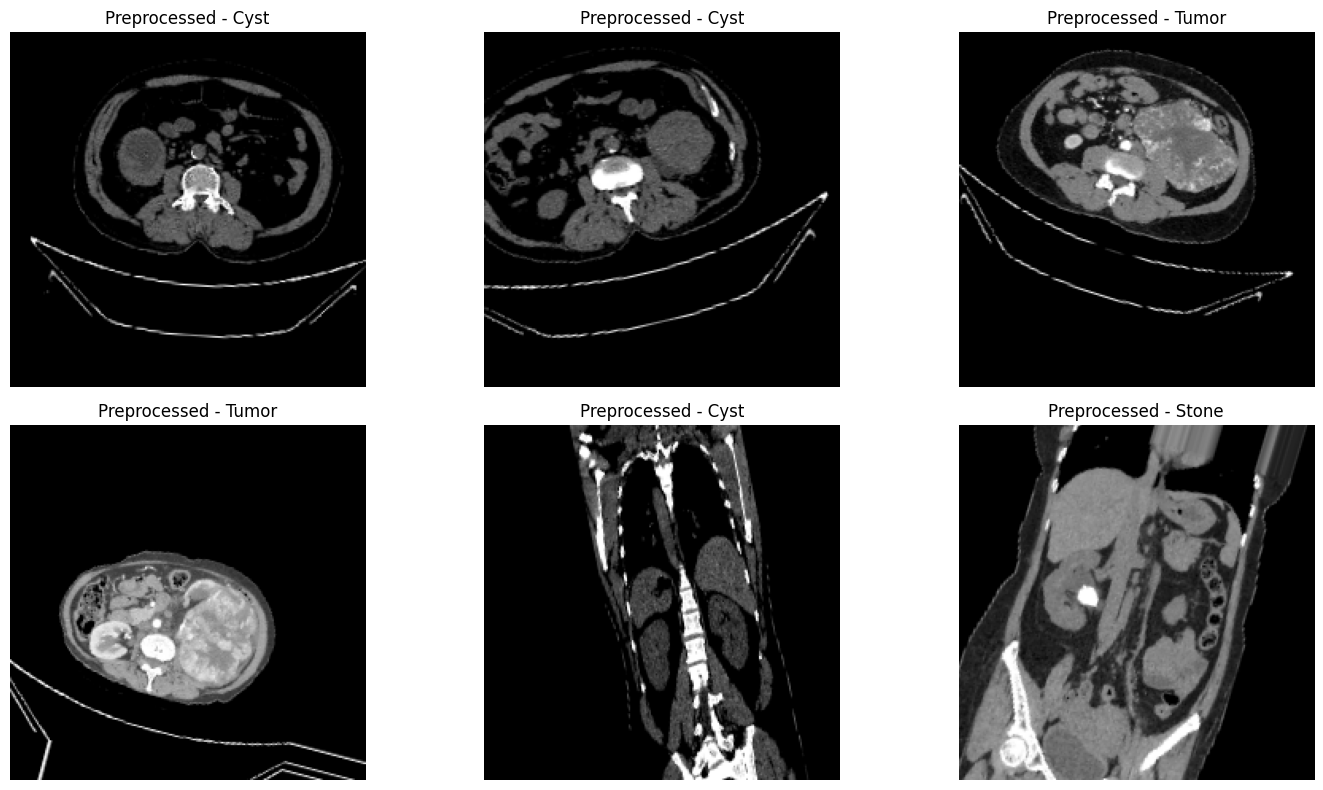

In [13]:
#show sample of augmented images
def show_augmented_images(dataset, num_images=6):

    images, labels = next(dataset)
    class_names    = list(dataset.class_indices.keys())

    plt.figure(figsize=(15, 8))

    for i in range(num_images):
        img = images[i]

        # The preprocessing function and rescale turn the image into float32.
        # For visualization, we need to handle this.
        # If the image is float, we assume it's in [0,1] range.
        if img.dtype == np.float32 or img.dtype == np.float64:
            # Clip to be safe, then scale to 0-255 and convert to uint8
            img_to_show = (np.clip(img, 0, 1) * 255).astype(np.uint8)
        else:
            img_to_show = img

        label = class_names[int(labels[i])]

        plt.subplot(2, 3, i + 1)
        plt.imshow(img_to_show)
        plt.title(f"Augmented - {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_augmented_images(train_ds, num_images=6)

In [14]:
model        = InceptionResNetV2(input_shape=(IMAGE_WIDTH , IMAGE_HEIGHT ,3), weights='imagenet', include_top=False, pooling='avg')

for layer in model.layers:
      layer.trainable = False

x     = Flatten()(model.output)
x     = Dense(num_classes, activation = 'softmax')(x)
model = Model(inputs = model.input, outputs = x)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# model.summary()

In [16]:
EarlyStoppingMonitor  = EarlyStopping(patience=10)
history               = model.fit(train_ds, epochs= 20, validation_data=valid_ds, callbacks= [EarlyStoppingMonitor])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 248s 692ms/step - accuracy: 0.6027 - loss: 0.9991 - val_accuracy: 0.7625 - val_loss: 0.6377
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 199s 538ms/step - accuracy: 0.7854 - loss: 0.5877 - val_accuracy: 0.8148 - val_loss: 0.5176
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 164s 526ms/step - accuracy: 0.8251 - loss: 0.4944 - val_accuracy: 0.8502 - val_loss: 0.4252
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 165s 528ms/step - accuracy: 0.8429 - loss: 0.4353 - val_accuracy: 0.8366 - val_loss: 0.4458
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 163s 524ms/step - accuracy: 0.8503 - loss: 0.4053 - val_accuracy: 0.8430 - val_loss: 0.4167
Epoch 6/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 165s 529ms/step - accuracy: 0.8675 - loss: 0.3790 - val_accuracy: 0.8398 - val_loss: 0.4311
Epoch 7/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 163s 521ms/step - accuracy: 0.8621 - loss: 0.3724 - val_accuracy: 0.8736 - val_loss: 0.3561
Epoch 8/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 163s 523ms/step - accuracy: 0.8680 -

In [17]:
model.save(model_path + '_20Epochs.keras')

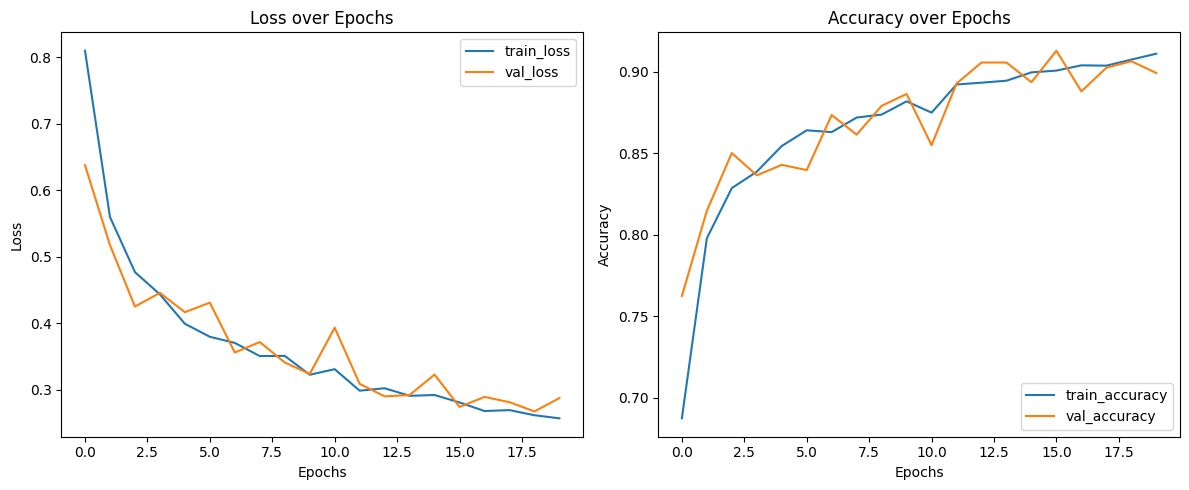

In [18]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss']    , label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy']    , label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend(loc='lower right')

plt.tight_layout()

# Save the figure
plt.savefig(results_path+ 'Loss_accuracy.png', dpi=300, bbox_inches='tight')

plt.show()

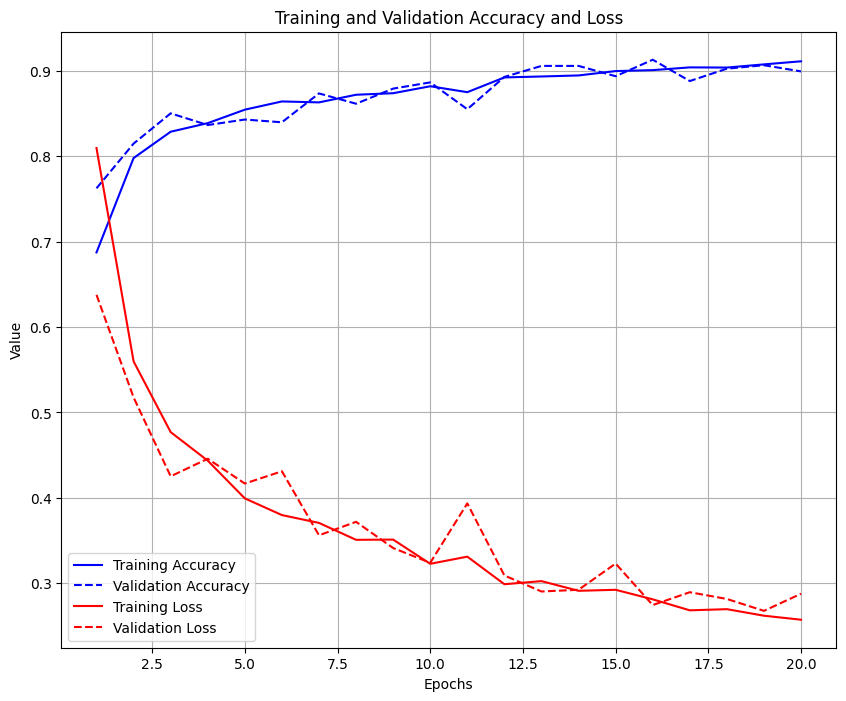

In [19]:
epochs  = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(10, 8))

# Plot accuracy
plt.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b--', label='Validation Accuracy')

# Plot loss
plt.plot(epochs, history.history['loss'], 'r-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r--', label='Validation Loss')

plt.title('Training and Validation Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.savefig(results_path+ 'Loss_accuracy_oneFigure.png', dpi=300, bbox_inches='tight')

plt.show()

In [20]:
#1- Evaluate the model on the test data using `evaluate`
_, accuracy = model.evaluate(test_ds, batch_size=32)
print()
print('evaluation accuracy is :  %.3f' % (accuracy * 100.0))
print()

40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 329ms/step - accuracy: 0.9479 - loss: 0.1733

evaluation accuracy is :  89.191



40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 473ms/step


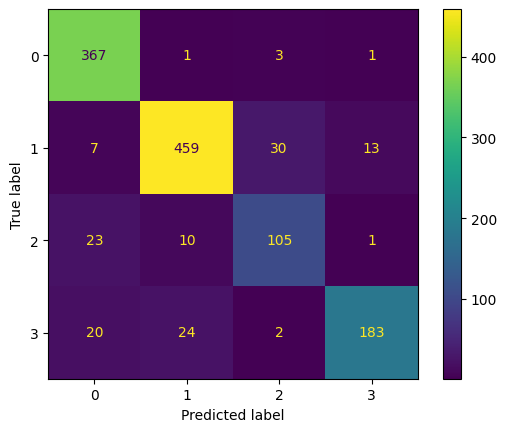

In [21]:
predictions            = model.predict(test_ds)
y_test                 = test_ds.classes

y_pred                 = np.argmax(predictions, axis=1)  # Get the index of the maximum value
cm                     = confusion_matrix(y_test, y_pred)

cmd                    = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(include_values= True, cmap='viridis', ax=None, xticks_rotation='horizontal')

# Save the figure
plt.savefig(results_path + 'Confusion Matrix.png', dpi=300, bbox_inches='tight')

plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       372
           1       0.93      0.90      0.92       509
           2       0.75      0.76      0.75       139
           3       0.92      0.80      0.86       229

    accuracy                           0.89      1249
   macro avg       0.87      0.86      0.86      1249
weighted avg       0.89      0.89      0.89      1249



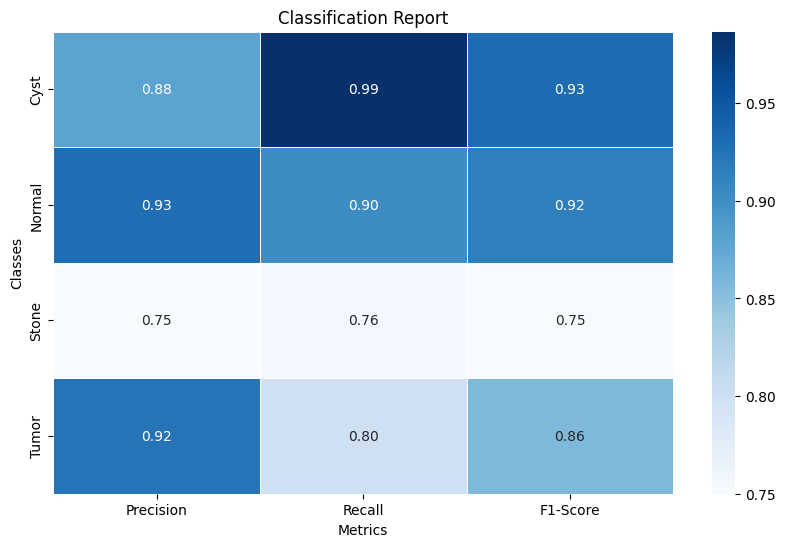

In [22]:
y_pred   = model.predict(test_ds)
y_test   = test_ds.classes

predicted_classes = [np.argmax(pred) for pred in predictions]

print(classification_report(y_test, predicted_classes))

report            = classification_report(y_test, predicted_classes, target_names=classes, output_dict=True)
metrics           = {label: report[label]        for label in classes if label in report}
precision_1       = [metrics[label]['precision'] for label in classes]
recall_1          = [metrics[label]['recall']    for label in classes]
f1_score_1        = [metrics[label]['f1-score']  for label in classes]

data = {
        'Precision': precision_1,
        'Recall'   : recall_1,
        'F1-Score' : f1_score_1
        }

df   = pd.DataFrame(data, index=classes)

plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')

# Save the figure
plt.savefig(results_path + 'Classification Report.png', dpi=300, bbox_inches='tight')

plt.show()

In [23]:
print ( ((precision_1[0]+ precision_1[1]+ precision_1[2]+ precision_1[3])/4)*100)
print ( ((recall_1[0]   + recall_1[1]   + recall_1[2]   + recall_1[3])/4)*100)
print ( ((f1_score_1[0] + f1_score_1[1] + f1_score_1[2] + f1_score_1[3])/4)*100)

87.08720362686664
86.07124084201962
86.384419367807


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step


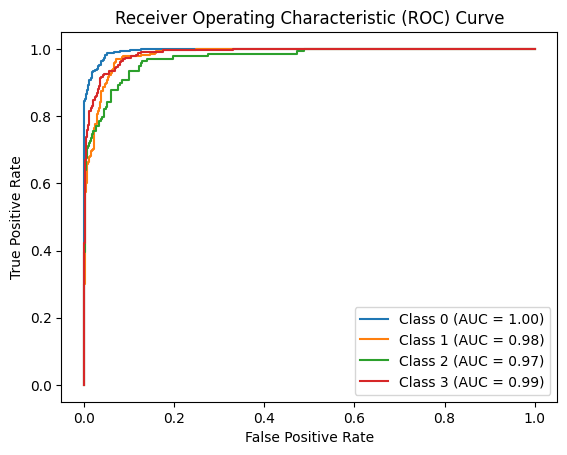

In [24]:
def plot_auc(predictions, y_test ):

    # Ensure that the target labels Y_test are in a 2-dimensional format
    if len(y_test.shape) == 1:
        y_test = np.eye(len(np.unique(y_test)))[y_test.astype(int)]

    # Compute the ROC curve and AUC score for each class
    fpr     = dict()
    tpr     = dict()
    roc_auc = dict()

    for i in range(y_test.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
        roc_auc[i]        = roc_auc_score(y_test[:, i], predictions[:, i])

    # Plot the ROC curve for each class
    plt.figure()
    for i in range(y_test.shape[1]):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    # Set the title and axis labels
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')

    # Save the figure
    plt.savefig(results_path + 'ROC.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

y_test = test_ds.classes
y_pred = model.predict(test_ds)
plot_auc(y_pred, y_test)

In [ ]:
# Extract true label from image path
def extract_true_label(img_path):

    print (img_path)
    folder_name = os.path.basename(os.path.dirname(img_path))
    print (folder_name)

    if "Cyst" in folder_name:
        return "Cyst"
    elif "Normal" in folder_name:
        return "Normal"
    elif "Stone" in folder_name:
        return "Stone"
    elif "Tumor" in folder_name:
        return "Tumor"

    return "Unknown"

# Load and preprocess image
def load_and_preprocess_image(img_path, target_size):

    if img_path.startswith('http'):
        response = requests.get(img_path)
        img      = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        img      = image.load_img(img_path)

    # Resize image explicitly
    img          = img.resize(target_size)

    # Convert to array and normalize
    img_array    = image.img_to_array(img) / 255.0
    img_array    = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img, img_array

In [ ]:
# Image path (URL or local)
img_path = test_dir + '/Cyst/Cyst- (100).jpg'#Cyst- (4).jpg

# Extract true label
true_label     = extract_true_label(img_path)

# Load and preprocess image
img, img_array = load_and_preprocess_image(img_path, img_size)

# Make prediction
pred       = model.predict(img_array)
pred_index = np.argmax(pred,axis=1)

if pred_index[0]   == 0:
  predicted_label = "Cyst"

elif pred_index[0] == 1:
  predicted_label = "Normal"

elif pred_index[0] == 2:
  predicted_label = "Stone"

elif pred_index[0] == 3:
  predicted_label = "Tumor"

# Display image
plt.imshow(img)
plt.axis('off')
plt.title(f"True = {true_label} | Predict = {predicted_label}")
plt.show()

# Print result
print(f"True = {true_label}    Predict = {predicted_label}")

In [ ]:
import matplotlib.pyplot as plt

def add_labels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i])  # Placing text slightly above the bar

# Data

metrics= ['DenseNet201', 'MobileNetV2', 'Xception', 'InceptionV3', 'InceptionResNetV2'] #exclude EffecientNet, ResNet
models = ['Accuracy'    ,'Precision', 'Recall', 'F1-Score']
data   = {
          'Accuracy' : [96.22,  87.11,  90.552, 91.914, 89.191],
          'Precision': [91.60,  87.20,  88.74 , 91.61, 87.087],
          'Recall'   : [88.40,  84.85,  87.98 , 88.40, 86.07],
          'F1-Score' : [89.66,  84.47,  88.25 , 89.66, 86.38]
          }

# Plotting
fig, ax   = plt.subplots(figsize=(12, 6))
bar_width = 0.2  # Width of each bar
space     = 0.1  # Space between model groups
positions = np.arange(len(models)) * (len(metrics) * bar_width + space)

#colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for metrics
colors  = ['lightblue', 'orange', 'yellow', 'plum', 'green']  # Colors for metrics

for i, metric in enumerate(metrics):
    # Collect metric values for all models
    values        = [data[model][i] for model in models]
    # Calculate bar positions for this metric
    bar_positions = positions + i * bar_width
    ax.bar(bar_positions, values, bar_width, label=metric, color=colors[i], edgecolor='black')

# Customize the plot
ax.set_xlabel('Performance Evaluation Metrics')
ax.set_ylabel('Percentage (%)')
ax.set_title('Proposed four deep learning models')
ax.set_xticks(positions + (len(metrics) * bar_width) / 2 - bar_width / 2)
ax.set_xticklabels(models)
ax.legend()

# Adjust y-axis to focus on the range of interest
ax.set_ylim(70, 103)

# Add grid for better readability
ax.grid(True, axis='y', linewidth=0.5, linestyle='-', alpha=0.7)
#add_labels(metrics, data)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
plt.savefig(results_path+'model_metrics_plot.png')

"""
colors in papers:
blue ...
lightblue
orange
move
green
yellow
"""

: 